In [4]:
%cd /work/adapting-CLIP-VGPs/
import torch
from tqdm import tqdm

checkpoint_path = '/work/adapting-CLIP-VGPs/checkpoints/checkpoint5.pt'
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
GPU = 7

from models.siamese import SiameseNet
from models.HCNN import HCNN
from collections import OrderedDict
model = HCNN()

# # Adjust for 'DataParallel' consistency
new_state_dict = OrderedDict()
for k, v in checkpoint['model_state_dict'].items():
    prefix = 'module.'
    name = k[len(prefix):]  # add `module.` prefix
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)
model.to(GPU)
model.eval()

from utils.heatmap_data import VGPsHeatmapsDataset
from torch.utils.data import DataLoader

heatmap_dataset = VGPsHeatmapsDataset(split="test")
batch_size = 100

heatmap_loader = DataLoader(
    dataset=heatmap_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_results = []

with torch.no_grad():
    for batch in tqdm(heatmap_loader):
        image_paths = batch['img_idx']
        phrase_pairs = [list(phrase_pair) for phrase_pair in zip(batch['phrases'][0],batch['phrases'][1])]
        left_heatmaps = batch['left_heatmap']
        right_heatmaps = batch['right_heatmap']
        labels = batch['label']
        
        left_tensor = left_heatmaps.unsqueeze(1).to(GPU)
        right_tensor = right_heatmaps.unsqueeze(1).to(GPU)
        label_tensor = labels.float().unsqueeze(1).to(GPU)
        
        outputs = model(left_tensor, right_tensor)
        # loss = criterion(outputs, label_tensor)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        TP = ((preds.squeeze(1) == 1) & (label_tensor.squeeze(1) == 1)).float().sum().item()
        FP = ((preds.squeeze(1) == 1) & (label_tensor.squeeze(1) == 0)).float().sum().item()
        FN = ((preds.squeeze(1) == 0) & (label_tensor.squeeze(1) == 1)).float().sum().item()
        TN = ((preds.squeeze(1) == 0) & (label_tensor.squeeze(1) == 0)).float().sum().item()            
                
        acc = (TP + TN) / len(image_paths)
        prec = TP / (TP + FP) if (TP + FP) > 0 else 0
        rec = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
        # print(f'Batch prec:{prec}')
        # print(f'Batch rec:{rec}')

        for i in range(len(image_paths)):
            test_results.append([image_paths[i], phrase_pairs[i], probs[i].item(), preds[i].item(), labels[i].item()])             

/work/adapting-CLIP-VGPs


  0%|          | 0/813 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 813/813 [05:32<00:00,  2.44it/s]


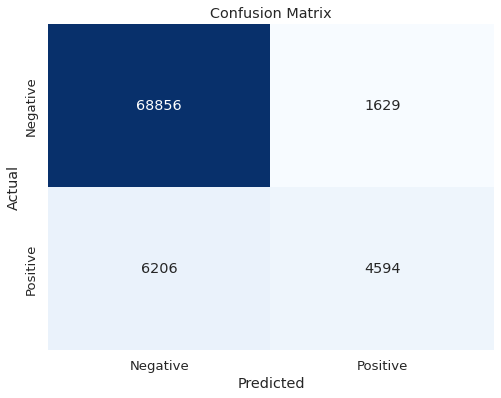

Accuracy: 0.9036107522913207
Precision: 0.7382291499276876
Recall: 0.42537037037037034
F1 Score: 0.5397403512894319


In [5]:
import pandas as pd

# val_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/siamese_test_results.csv')
pred = [row[3] for row in test_results]
gt = [row[4] for row in test_results]

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Replace actual_labels and predicted_labels with your own data
cm = confusion_matrix(gt, pred)

# Define class labels
class_labels = ['Negative', 'Positive']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision
precision = precision_score(gt, pred)

# Calculate recall
recall = recall_score(gt, pred)

# Calculate F1 score
f1 = f1_score(gt, pred)

# Calculate accuracy
acc = sum(x==y for x,y in zip(gt,pred))/len(gt)

print(f'Accuracy: {acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

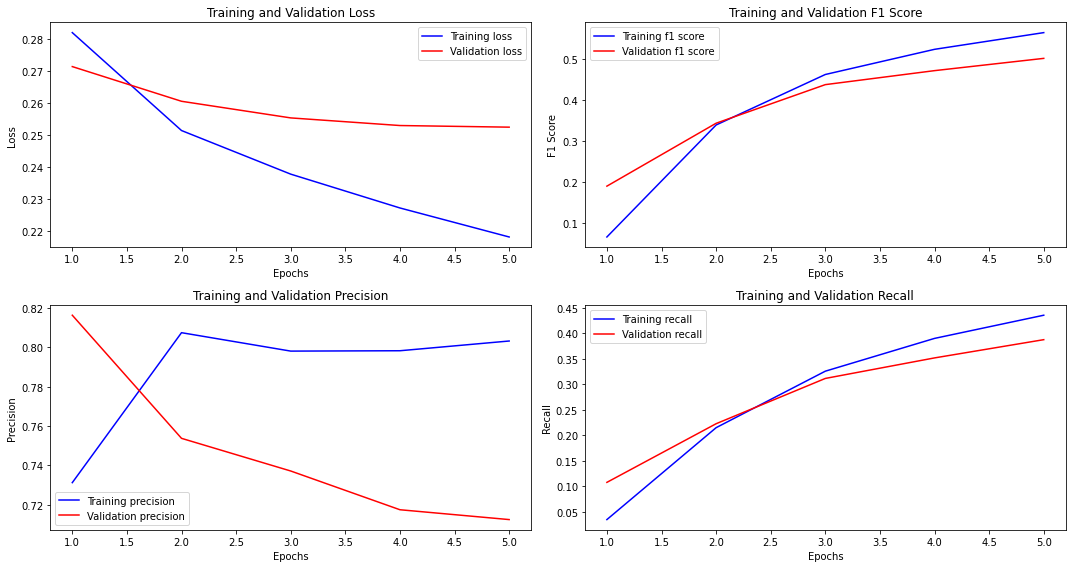

In [2]:
import matplotlib.pyplot as plt
import json

# Load data from JSON
with open('/work/adapting-CLIP-VGPs/checkpoints/training_history.json', 'r') as file:
    data = json.load(file)

train_loss = data['train_loss']
train_acc = data['train_acc']
train_prec = data['train_prec']
train_rec = data['train_rec']
train_f1 = data['train_f1']
valid_loss = data['valid_loss']
valid_acc = data['valid_acc']
valid_prec = data['valid_prec']
valid_rec = data['valid_rec']
valid_f1 = data['valid_f1']

epochs = range(1, len(train_loss) + 1)
epoch_ticks = range(0, len(train_loss)+1, 4)

# Create subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))

# Plot training and validation loss
ax1.plot(epochs, train_loss, 'b', label='Training loss')
ax1.plot(epochs, valid_loss, 'r', label='Validation loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
# ax1.set_xticks(epoch_ticks)

# Plot training and validation f1
ax2.plot(epochs, train_f1, 'b', label='Training f1 score')
ax2.plot(epochs, valid_f1, 'r', label='Validation f1 score')
ax2.set_title('Training and Validation F1 Score')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('F1 Score')
ax2.legend()
# ax2.set_xticks(epoch_ticks)

# Plot training and validation precision
ax3.plot(epochs, train_prec, 'b', label='Training precision')
ax3.plot(epochs, valid_prec, 'r', label='Validation precision')
ax3.set_title('Training and Validation Precision')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Precision')
ax3.legend()
# ax3.set_xticks(epoch_ticks)

# Plot training and validation recall
ax4.plot(epochs, train_rec, 'b', label='Training recall')
ax4.plot(epochs, valid_rec, 'r', label='Validation recall')
ax4.set_title('Training and Validation Recall')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Recall')
ax4.legend()
# ax4.set_xticks(epoch_ticks)

plt.tight_layout()
plt.show()

In [2]:
%cd /work/adapting-CLIP-VGPs/
import torch
from tqdm import tqdm

checkpoint_path = '/work/adapting-CLIP-VGPs/checkpoints/text+heatmap/checkpoint10.pt'
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
GPU = 5

# from models.siamese import SiameseNet
# from models.HCNN import HCNN
from models.text_hm_cnn import TextHeatmapCNN
from collections import OrderedDict
model = TextHeatmapCNN()

# # Adjust for 'DataParallel' consistency
new_state_dict = OrderedDict()
for k, v in checkpoint['model_state_dict'].items():
    prefix = 'module.'
    name = k[len(prefix):]  # add `module.` prefix
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)
model.to(GPU)
model.eval()

from utils.heatmap_data import VGPsHeatmapsDataset
from torch.utils.data import DataLoader

heatmap_dataset = VGPsHeatmapsDataset(split="test")
batch_size = 100

heatmap_loader = DataLoader(
    dataset=heatmap_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_results = []

with torch.no_grad():
    for batch in tqdm(heatmap_loader):
        image_paths = batch['img_idx']
        phrase_pairs = [list(phrase_pair) for phrase_pair in zip(batch['phrases'][0],batch['phrases'][1])]
        left_text_ft = batch['left_text_emb']
        right_text_ft = batch['right_text_emb']
        left_heatmaps = batch['left_heatmap']
        right_heatmaps = batch['right_heatmap']
        labels = batch['label']
        
        left_heatmaps = left_heatmaps.unsqueeze(1).to(GPU)
        right_heatmaps = right_heatmaps.unsqueeze(1).to(GPU)
        left_text_ft = left_text_ft.squeeze(1).to(GPU)
        right_text_ft = right_text_ft.squeeze(1).to(GPU)
        label_tensor = labels.float().unsqueeze(1).to(GPU)
        
        outputs = model(left_heatmaps, right_heatmaps, left_text_ft, right_text_ft)
        # loss = criterion(outputs, label_tensor)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        TP = ((preds.squeeze(1) == 1) & (label_tensor.squeeze(1) == 1)).float().sum().item()
        FP = ((preds.squeeze(1) == 1) & (label_tensor.squeeze(1) == 0)).float().sum().item()
        FN = ((preds.squeeze(1) == 0) & (label_tensor.squeeze(1) == 1)).float().sum().item()
        TN = ((preds.squeeze(1) == 0) & (label_tensor.squeeze(1) == 0)).float().sum().item()            
                
        acc = (TP + TN) / len(image_paths)
        prec = TP / (TP + FP) if (TP + FP) > 0 else 0
        rec = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
        # print(f'Batch prec:{prec}')
        # print(f'Batch rec:{rec}')

        for i in range(len(image_paths)):
            test_results.append([image_paths[i], phrase_pairs[i], probs[i].item(), preds[i].item(), labels[i].item()])             

/work/adapting-CLIP-VGPs


  0%|          | 0/813 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 813/813 [06:31<00:00,  2.08it/s]


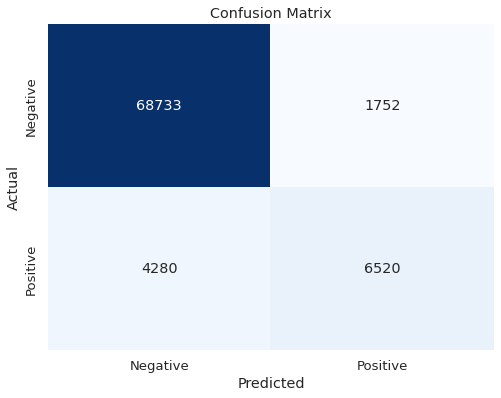

Accuracy: 0.9257919665374915
Precision: 0.7882011605415861
Recall: 0.6037037037037037
F1 Score: 0.6837248322147651


In [3]:
import pandas as pd

# val_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/siamese_test_results.csv')
pred = [row[3] for row in test_results]
gt = [row[4] for row in test_results]

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Replace actual_labels and predicted_labels with your own data
cm = confusion_matrix(gt, pred)

# Define class labels
class_labels = ['Negative', 'Positive']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision
precision = precision_score(gt, pred)

# Calculate recall
recall = recall_score(gt, pred)

# Calculate F1 score
f1 = f1_score(gt, pred)

# Calculate accuracy
acc = sum(x==y for x,y in zip(gt,pred))/len(gt)

print(f'Accuracy: {acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

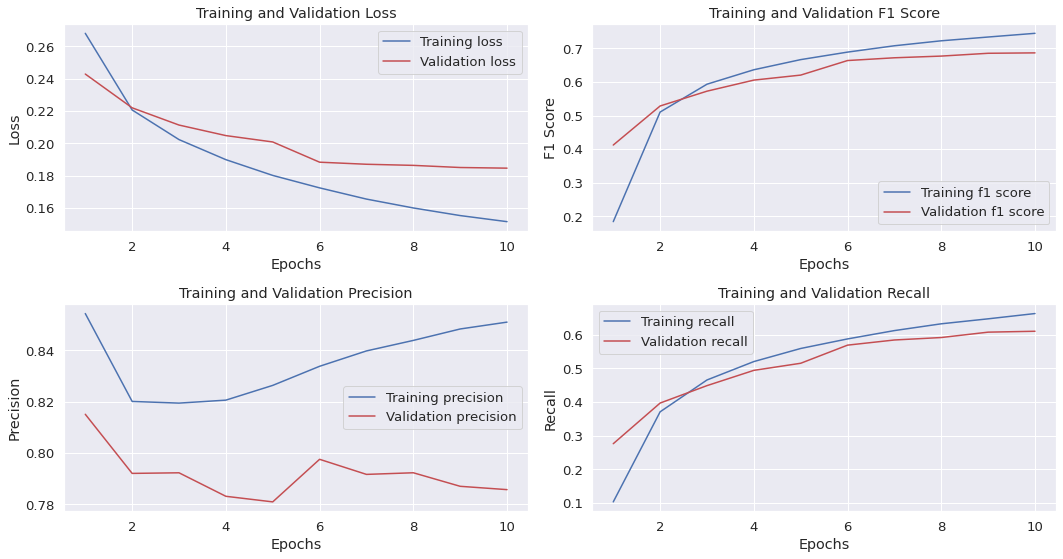

In [4]:
import matplotlib.pyplot as plt
import json

# Load data from JSON
with open('/work/adapting-CLIP-VGPs/checkpoints/text+heatmap/1-10training_history.json', 'r') as file:
    data = json.load(file)

train_loss = data['train_loss']
train_acc = data['train_acc']
train_prec = data['train_prec']
train_rec = data['train_rec']
train_f1 = data['train_f1']
valid_loss = data['valid_loss']
valid_acc = data['valid_acc']
valid_prec = data['valid_prec']
valid_rec = data['valid_rec']
valid_f1 = data['valid_f1']

epochs = range(1, len(train_loss) + 1)
epoch_ticks = range(0, len(train_loss)+1, 4)

# Create subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))

# Plot training and validation loss
ax1.plot(epochs, train_loss, 'b', label='Training loss')
ax1.plot(epochs, valid_loss, 'r', label='Validation loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
# ax1.set_xticks(epoch_ticks)

# Plot training and validation f1
ax2.plot(epochs, train_f1, 'b', label='Training f1 score')
ax2.plot(epochs, valid_f1, 'r', label='Validation f1 score')
ax2.set_title('Training and Validation F1 Score')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('F1 Score')
ax2.legend()
# ax2.set_xticks(epoch_ticks)

# Plot training and validation precision
ax3.plot(epochs, train_prec, 'b', label='Training precision')
ax3.plot(epochs, valid_prec, 'r', label='Validation precision')
ax3.set_title('Training and Validation Precision')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Precision')
ax3.legend()
# ax3.set_xticks(epoch_ticks)

# Plot training and validation recall
ax4.plot(epochs, train_rec, 'b', label='Training recall')
ax4.plot(epochs, valid_rec, 'r', label='Validation recall')
ax4.set_title('Training and Validation Recall')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Recall')
ax4.legend()
# ax4.set_xticks(epoch_ticks)

plt.tight_layout()
plt.show()

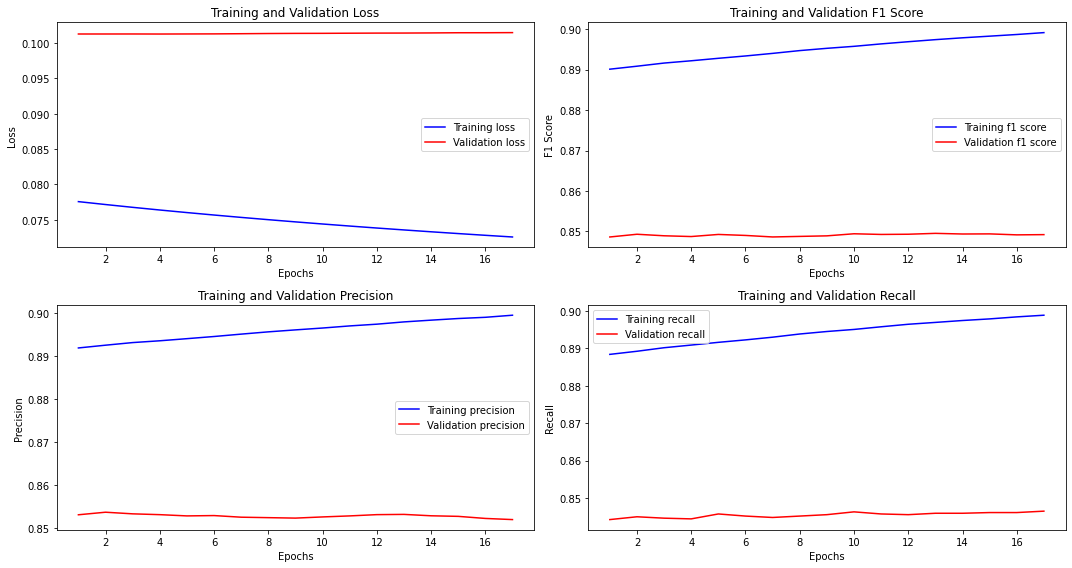

In [4]:
import matplotlib.pyplot as plt
import json

# Load data from JSON
with open('/work/adapting-CLIP-VGPs/checkpoints/text_only/training_history.json', 'r') as file:
    data = json.load(file)

train_loss = data['train_loss']
train_acc = data['train_acc']
train_prec = data['train_prec']
train_rec = data['train_rec']
train_f1 = data['train_f1']
valid_loss = data['valid_loss']
valid_acc = data['valid_acc']
valid_prec = data['valid_prec']
valid_rec = data['valid_rec']
valid_f1 = data['valid_f1']

epochs = range(1, len(train_loss) + 1)
epoch_ticks = range(0, len(train_loss)+1, 4)

# Create subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))

# Plot training and validation loss
ax1.plot(epochs, train_loss, 'b', label='Training loss')
ax1.plot(epochs, valid_loss, 'r', label='Validation loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
# ax1.set_xticks(epoch_ticks)

# Plot training and validation f1
ax2.plot(epochs, train_f1, 'b', label='Training f1 score')
ax2.plot(epochs, valid_f1, 'r', label='Validation f1 score')
ax2.set_title('Training and Validation F1 Score')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('F1 Score')
ax2.legend()
# ax2.set_xticks(epoch_ticks)

# Plot training and validation precision
ax3.plot(epochs, train_prec, 'b', label='Training precision')
ax3.plot(epochs, valid_prec, 'r', label='Validation precision')
ax3.set_title('Training and Validation Precision')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Precision')
ax3.legend()
# ax3.set_xticks(epoch_ticks)

# Plot training and validation recall
ax4.plot(epochs, train_rec, 'b', label='Training recall')
ax4.plot(epochs, valid_rec, 'r', label='Validation recall')
ax4.set_title('Training and Validation Recall')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Recall')
ax4.legend()
# ax4.set_xticks(epoch_ticks)

plt.tight_layout()
plt.show()